## Workflow
- [x] Load image and convert to gray.
- [x] Find edges (Apply Canny).
- [x] Mask a ROI (Region Of Interest).
- [x] Find lines (Hough Lines).
- [x] Formulate lane lines (2 lines).
- [x] Draw the lanes.
- [x] Combine all together in one pipeline function.
- [x] Process video.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Convert image to gray
- Input: Colored image
- Output: Grayscaled image

In [2]:
def convert_to_gray(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

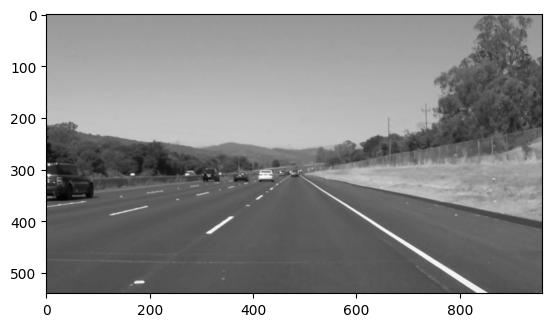

In [9]:
img = cv2.imread('./test_images/solidWhiteRight.jpg')
gray = convert_to_gray(img)
plt.imshow(gray, cmap='gray');

## Find Edges
- Input: Grayscale image
- Output: Edges binary image

In [8]:
def find_edges(img):
  blur = cv2.GaussianBlur(img, (5,5), 0)
  return cv2.Canny(blur, 50, 150)

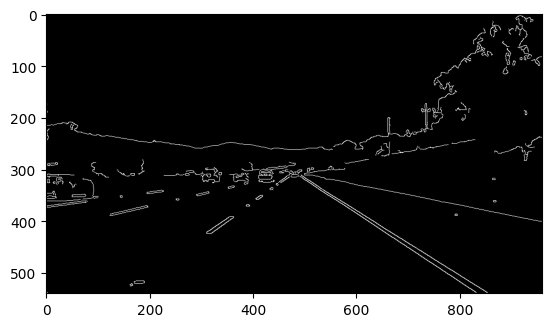

In [10]:
edges = find_edges(gray)
plt.imshow(edges, cmap='gray');

## Apply RIO
- Input: Edges image
- Output: Masked image

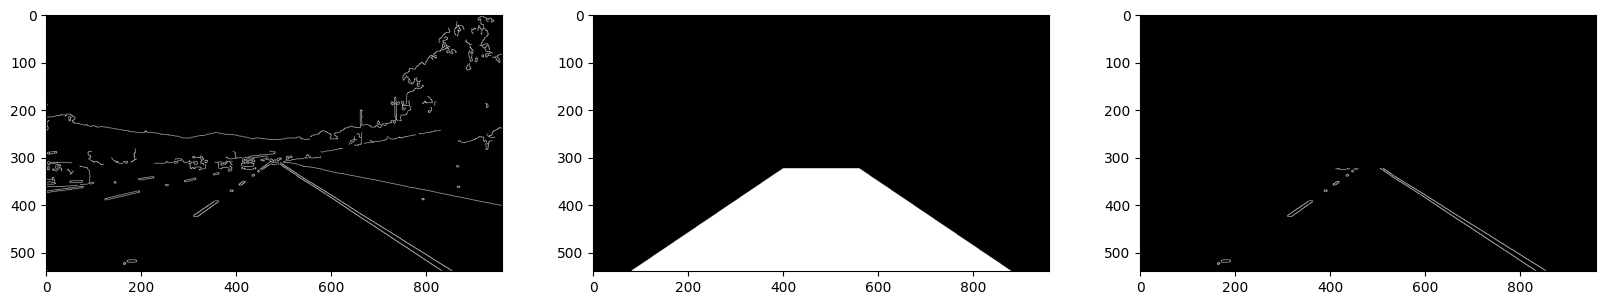

In [58]:
mask = np.zeros_like(edges)

vert = np.array(
  [
    [
      (int(mask.shape[1]*5/12), int(mask.shape[0]*3/5)),
      (int(mask.shape[1]*7/12), int(mask.shape[0]*3/5)),
      (int(mask.shape[1]*11/12), mask.shape[0]),
      (int(mask.shape[1]/12), mask.shape[0])
    ]
  ]
)
cv2.fillPoly(mask, vert, 255)
masked = cv2.bitwise_and(edges, mask)

# Visualize
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(edges, cmap='gray')
ax1.imshow(mask, cmap='gray')
ax2.imshow(masked, cmap='gray');

In [59]:
def mask_roi(img):
  mask = np.zeros_like(edges)

  vert = np.array(
    [
      [
        (int(mask.shape[1]*5/12), int(mask.shape[0]*3/5)),
        (int(mask.shape[1]*7/12), int(mask.shape[0]*3/5)),
        (int(mask.shape[1]*11/12), mask.shape[0]),
        (int(mask.shape[1]/12), mask.shape[0])
      ]
    ]
  )
  cv2.fillPoly(mask, vert, 255)
  masked = cv2.bitwise_and(edges, mask)
  return masked

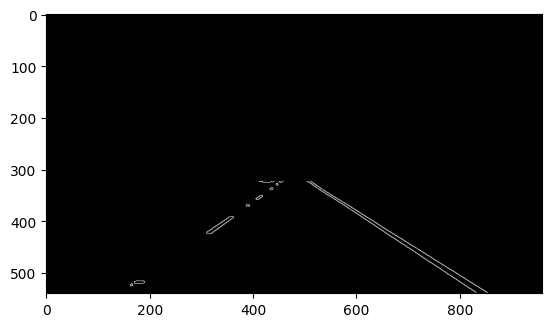

In [60]:
plt.imshow(mask_roi(edges), cmap='gray');

## Finding lines in the image (Hough Lines)

- Input: masked image
- Output: array of lines 

In [73]:
def hough_lines(img):
  return cv2.HoughLinesP(img, 4, np.pi/180, 10, 5, 10)

In [80]:
def draw_lines(img, lines):
  lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(lines_img, (x1, y1), (x2, y2), [255,0,0], 15)
  return lines_img

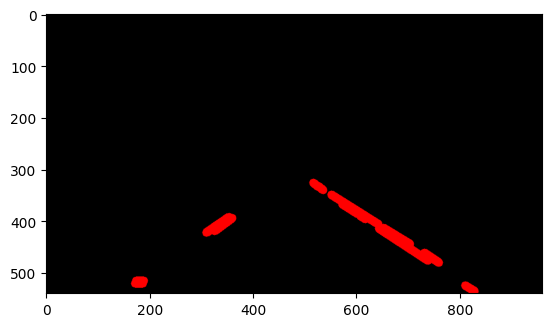

In [81]:
lines = hough_lines(masked)
lined_img = draw_lines(masked, lines)
plt.imshow(lined_img);

## Formulate lane lines
- Input: array of lines
- Output: 2 lines respresinting lanes

In [82]:
def formulate_lanes(lines, img):
  negative_slopes = []
  positive_slopes = []

  negative_intercepts = []
  positive_intercepts = []

  y_min = img.shape[0]
  y_max = img.shape[0]

  for line in lines:
    for x1, y1, x2, y2 in line:
      slope = (y2-y1) / (x2-x1)
      intercept = y2 - slope*x2

      y_min = min(y_min, y1, y2)

      if slope > 0.0:
        positive_slopes.append(slope)
        positive_intercepts.append(intercept)

      elif slope < 0.0:
        negative_slopes.append(slope)
        negative_intercepts.append(intercept)
  
  positive_slope = np.mean(positive_slopes)
  negative_slope = np.mean(negative_slopes)

  positive_intercept = np.mean(positive_intercepts)
  negative_intercept = np.mean(negative_intercepts)

  pts = [
    [[0,0, 0,0]],
    [[0,0, 0,0]]
  ]

  # +ve
  if len(positive_slopes) > 0:
    x_max = (y_max - positive_intercept) / positive_slope
    x_min = (y_min - positive_intercept) / positive_slope
    pts[0][0] = [x_min, y_min, x_max, y_max]
  
  if len(negative_slopes) > 0:
    x_max = (y_max - negative_intercept) / negative_slope
    x_min = (y_min - negative_intercept) / negative_slope
    pts[1][0] = [x_min, y_min, x_max, y_max]
  
  return np.array(pts, dtype=np.int32)

In [93]:
lanes = formulate_lanes(lines, masked)

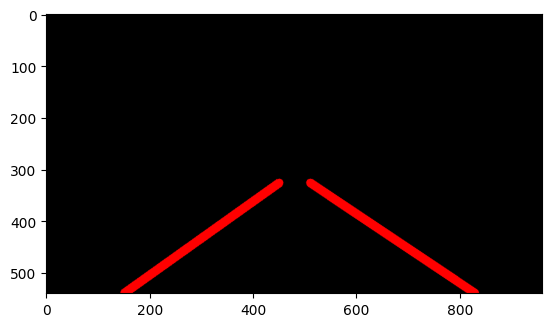

In [94]:
lanes_img = draw_lines(masked, lanes)
plt.imshow(lanes_img);

## Draw lanes
- Input: Black image with 2 lanes
- Output: Image with 2 lanes

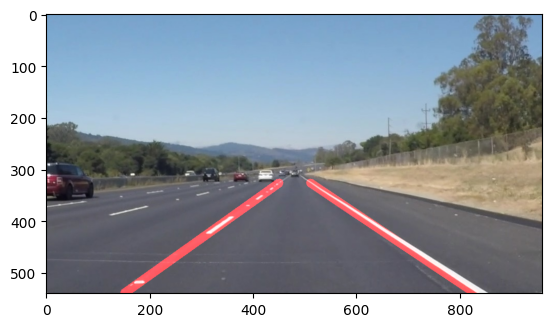

In [86]:
output = cv2.addWeighted(img[:,:,::-1], 1, lanes_img, 1, 0)
plt.imshow(output);

## Combine all pipeline in one function

In [110]:
def process_image(img):
  gray = convert_to_gray(img)
  edges = find_edges(gray)
  masked = mask_roi(edges)
  lines = hough_lines(masked)
  lanes = formulate_lanes(lines, masked)
  lined_img = draw_lines(masked, lanes)
  output = cv2.addWeighted(img, 1, lined_img, 1, 0)
  return output

In [99]:
img1 = cv2.imread('test_images/solidWhiteCurve.jpg')
img2 = cv2.imread('test_images/solidWhiteRight.jpg')
img3 = cv2.imread('test_images/solidYellowCurve.jpg')
img4 = cv2.imread('test_images/solidYellowCurve2.jpg')
img5 = cv2.imread('test_images/solidYellowLeft.jpg')

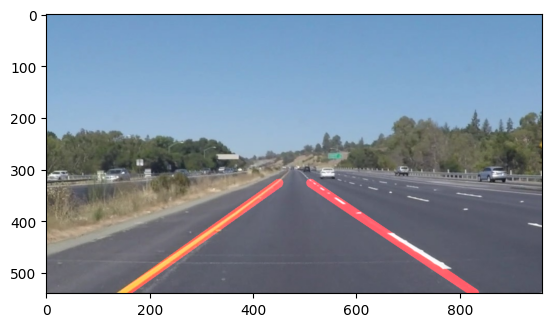

In [104]:
output = process_image(img5)
plt.imshow(output);

## Apply pipeline on a video

In [107]:
from IPython.display import HTML

input_path = './test_videos/solidWhiteRight.mp4'
output_path = './test_videos/output.mp4'

HTML(f"""
     <video width="960" height="540" controls>
      <source src="{input_path}">
     </ video>
""")

In [111]:
from moviepy.editor import VideoFileClip

input_video = VideoFileClip(input_path)
output_video = input_video.fl_image(process_image)
output_video.write_videofile(output_path, audio=False)

Moviepy - Building video ./test_videos/output.mp4.
Moviepy - Writing video ./test_videos/output.mp4



Moviepy - Done !
Moviepy - video ready ./test_videos/output.mp4


In [112]:
HTML(f"""
     <video width="960" height="540" controls>
      <source src="{output_path}">
     </ video>
""")